In [1]:
!pip install kaggle dagshub mlflow -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip walmart-recruiting-store-sales-forecasting.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 550MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [5]:
!unzip train.csv.zip
!unzip stores.csv.zip
!unzip features.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.
Archive:  features.csv.zip
  inflating: features.csv            
Archive:  test.csv.zip
  inflating: test.csv                


In [221]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import dagshub
import mlflow
import mlflow.pytorch
import joblib
import warnings

In [222]:
class Config:
    lookback = 20
    horizon = 1
    batch_size = 64
    epochs = 10
    lr = 1e-3
    random_state = 42
    test_size = 0.2
    model_name = "DLinear"
    experiment_name = "DLinear_Training"
    lag_features = [1, 2, 3, 4, 8, 12, 24, 52]
    use_rolling_stats = True
    rolling_windows = [4, 8, 12]

config = Config()

In [223]:
dagshub.init(repo_owner='Cimbir', repo_name='Store-Sales-Forecasting', mlflow=True)

Initialized MLflow to track repo "Cimbir/Store-Sales-Forecasting"

Repository Cimbir/Store-Sales-Forecasting initialized!

In [224]:
warnings.filterwarnings('ignore')

In [225]:
torch.manual_seed(42)
np.random.seed(42)

In [226]:
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

In [227]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [228]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [229]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


# Evaluation function

In [230]:
def weighted_mae_loss(y_pred, y_true, is_holiday):
    weights = torch.where(is_holiday, 5.0, 1.0).to(y_pred.device)
    return torch.sum(weights * torch.abs(y_true - y_pred)) / torch.sum(weights)

In [231]:
features['Date'] = pd.to_datetime(features['Date'])
train['Date'] = pd.to_datetime(train['Date'])

df = pd.merge(train, features, on=['Store', 'Date'], how='left')
df = pd.merge(df, stores, on='Store', how='left')
df = df.rename(columns={'IsHoliday_x': 'IsHoliday'}).drop(columns=['IsHoliday_y'])
df.fillna(0, inplace=True)
df.sort_values(['Store', 'Dept', 'Date'], inplace=True)

In [232]:
def create_lag_features(ts, lag_features, rolling_windows=None):
    features_list = []
    features_list.append(ts.values.reshape(-1, 1))

    for lag in lag_features:
        lagged = ts.shift(lag).values.reshape(-1, 1)
        features_list.append(lagged)

    if rolling_windows:
        for window in rolling_windows:
            roll_mean = ts.rolling(window=window, min_periods=1).mean().values.reshape(-1, 1)
            features_list.append(roll_mean)

            roll_std = ts.rolling(window=window, min_periods=1).std().fillna(0).values.reshape(-1, 1)
            features_list.append(roll_std)

    feature_matrix = np.concatenate(features_list, axis=1)
    return feature_matrix

In [233]:
def generate_all_windows_with_lags(df, lookback, horizon, lag_features, rolling_windows=None):
    X, y, meta = [], [], []

    for (store, dept), group in df.groupby(['Store', 'Dept']):
        ts = group.set_index('Date')['Weekly_Sales'].resample('W-FRI').sum().sort_index()
        dates = ts.index

        if len(ts) < max(lag_features) + lookback + horizon:
            continue

        if rolling_windows:
            feature_matrix = create_lag_features(ts, lag_features, rolling_windows)
        else:
            feature_matrix = create_lag_features(ts, lag_features)

        max_lag = max(lag_features) if lag_features else 0
        start_idx = max_lag + lookback

        for i in range(start_idx, len(ts) - horizon + 1):
            X_window = feature_matrix[i - lookback:i]

            y_window = ts.iloc[i:i + horizon].values

            X.append(X_window)
            y.append(y_window)
            meta.append((store, dept, dates[i + horizon - 1]))

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32), np.array(meta)

In [234]:
X, y, meta = generate_all_windows_with_lags(
    df, config.lookback, config.horizon,
    config.lag_features,
    config.rolling_windows if config.use_rolling_stats else None
)

print(f"Generated data shapes:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Number of features: {X.shape[2]}")

Generated data shapes:
X shape: (217579, 20, 15)
y shape: (217579, 1)
Number of features: 15


In [235]:
def time_based_split(X, y, meta, test_size=0.2):
    dates = [m[2] for m in meta]
    sorted_indices = np.argsort(dates)

    split_idx = int(len(sorted_indices) * (1 - test_size))
    train_idx = sorted_indices[:split_idx]
    val_idx = sorted_indices[split_idx:]

    return X[train_idx], X[val_idx], y[train_idx], y[val_idx], meta[train_idx], meta[val_idx]

X_train, X_val, y_train, y_val, meta_train, meta_val = time_based_split(
    X, y, meta, test_size=config.test_size
)

In [236]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, meta, df):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        meta_df = pd.DataFrame(meta, columns=["Store", "Dept", "Date"])
        meta_df['Date'] = pd.to_datetime(meta_df['Date'])
        self.meta = meta_df.to_dict("records")
        flags = df[['Store', 'Dept', 'Date', 'IsHoliday']].drop_duplicates()
        merged = meta_df.merge(flags, on=['Store', 'Dept', 'Date'], how='left')
        self.is_holiday = torch.tensor(merged['IsHoliday'].astype(bool).values, dtype=torch.bool)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.is_holiday[idx]

In [237]:
train_ds = TimeSeriesDataset(X_train, y_train, meta_train, df)
val_ds = TimeSeriesDataset(X_val, y_val, meta_val, df)
train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config.batch_size)

In [238]:
class DLinearWithLags(nn.Module):
    def __init__(self, lookback, horizon, n_features):
        super().__init__()
        self.lookback = lookback
        self.horizon = horizon
        self.n_features = n_features
        self.linear = nn.Linear(lookback * n_features, horizon)

        self.use_mlp = True
        if self.use_mlp:
            hidden_size = min(256, lookback * n_features // 2)
            self.mlp = nn.Sequential(
                nn.Linear(lookback * n_features, hidden_size),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(hidden_size, horizon)
            )

    def forward(self, x):
        batch_size = x.size(0)
        x_flat = x.view(batch_size, -1)

        if self.use_mlp:
            return self.mlp(x_flat)
        else:
            return self.linear(x_flat)

In [239]:
def evaluate_model(model, data_loader, dataset_name="Dataset"):
    model.eval()
    all_predictions = []
    all_targets = []
    all_holidays = []
    all_stores = []

    with torch.no_grad():
        for i, (batch_x, batch_y, batch_holiday) in enumerate(data_loader):
            predictions = model(batch_x)

            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_targets.extend(batch_y.cpu().numpy().flatten())
            all_holidays.extend(batch_holiday.cpu().numpy())

            batch_size = len(batch_x)
            start_idx = i * data_loader.batch_size
            end_idx = start_idx + batch_size
            stores = [data_loader.dataset.meta[j]['Store'] for j in range(start_idx, min(end_idx, len(data_loader.dataset.meta)))]
            all_stores.extend(stores)

    y_true = np.array(all_targets)
    y_pred = np.array(all_predictions)
    errors = y_pred - y_true

    weights = np.where(all_holidays, 5.0, 1.0)
    wmae = np.sum(weights * np.abs(errors)) / np.sum(weights)

    mean_error = np.mean(errors)
    bias_direction = "over-predicting" if mean_error > 0 else "under-predicting"

    error_std = np.std(errors)

    store_df = pd.DataFrame({
        'store': all_stores,
        'actual': y_true,
        'predicted': y_pred,
        'abs_error': np.abs(errors)
    })

    store_stats = store_df.groupby('store')['abs_error'].agg(['mean', 'count']).reset_index()
    store_stats = store_stats[store_stats['count'] >= 5]

    print(f"\n{'='*50}")
    print(f"{dataset_name.upper()} EVALUATION RESULTS")
    print(f"{'='*50}")
    print(f"WMAE (Weighted MAE): {wmae:.2f}")
    print(f"Bias: {mean_error:.2f} (Model is {bias_direction} by ${abs(mean_error):.2f} on average)")
    print(f"Error Std Dev: {error_std:.2f} (Prediction consistency)")
    print(f"Store Performance:")
    print(f"Best Store MAE: {store_stats['mean'].min():.2f}")
    print(f"Worst Store MAE: {store_stats['mean'].max():.2f}")
    print(f"Average Store MAE: {store_stats['mean'].mean():.2f}")
    print(f"Store Performance Range: {store_stats['mean'].max() - store_stats['mean'].min():.2f}")

    return y_true, y_pred, wmae, mean_error, error_std, store_stats

In [240]:
def plot_actual_vs_predicted(y_true, y_pred, dataset_name="Dataset"):
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred, alpha=0.6, s=20)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Sales', fontsize=12)
    plt.ylabel('Predicted Sales', fontsize=12)
    plt.title(f'{dataset_name} - Actual vs Predicted Sales', fontsize=14)
    plt.grid(True, alpha=0.3)

    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
             transform=plt.gca().transAxes, fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

In [241]:
n_features = X.shape[2]
print(f"\nFeature breakdown:")
print(f"Original sales: 1 feature")
print(f"Lag features: {len(config.lag_features)} features")
if config.use_rolling_stats:
    print(f"Rolling statistics: {len(config.rolling_windows) * 2} features (mean + std)")
print(f"Total features: {n_features}")


Feature breakdown:
Original sales: 1 feature
Lag features: 8 features
Rolling statistics: 6 features (mean + std)
Total features: 15


Starting training...
Epoch 1/10: Train Loss: 144531.3196, Val Loss: 102194.9268
Epoch 2/10: Train Loss: 133933.0991, Val Loss: 105619.9079
Epoch 3/10: Train Loss: 130791.2831, Val Loss: 81136.8054
Epoch 4/10: Train Loss: 129715.2758, Val Loss: 80343.4127
Epoch 5/10: Train Loss: 128238.4233, Val Loss: 103912.3348
Epoch 6/10: Train Loss: 128588.0077, Val Loss: 79969.4012
Epoch 7/10: Train Loss: 126648.5534, Val Loss: 151912.3103
Epoch 8/10: Train Loss: 125537.2052, Val Loss: 84237.3414
Epoch 9/10: Train Loss: 124834.4773, Val Loss: 133427.5364
Epoch 10/10: Train Loss: 123848.0882, Val Loss: 127712.3927

TRAINING SET EVALUATION RESULTS
WMAE (Weighted MAE): 2245.16
Bias: 1081.60 (Model is over-predicting by $1081.60 on average)
Error Std Dev: 5485.77 (Prediction consistency)
Store Performance:
Best Store MAE: 1940.82
Worst Store MAE: 2349.05
Average Store MAE: 2132.34
Store Performance Range: 408.23

VALIDATION SET EVALUATION RESULTS
WMAE (Weighted MAE): 1885.12
Bias: 1487.36 (Model is ove

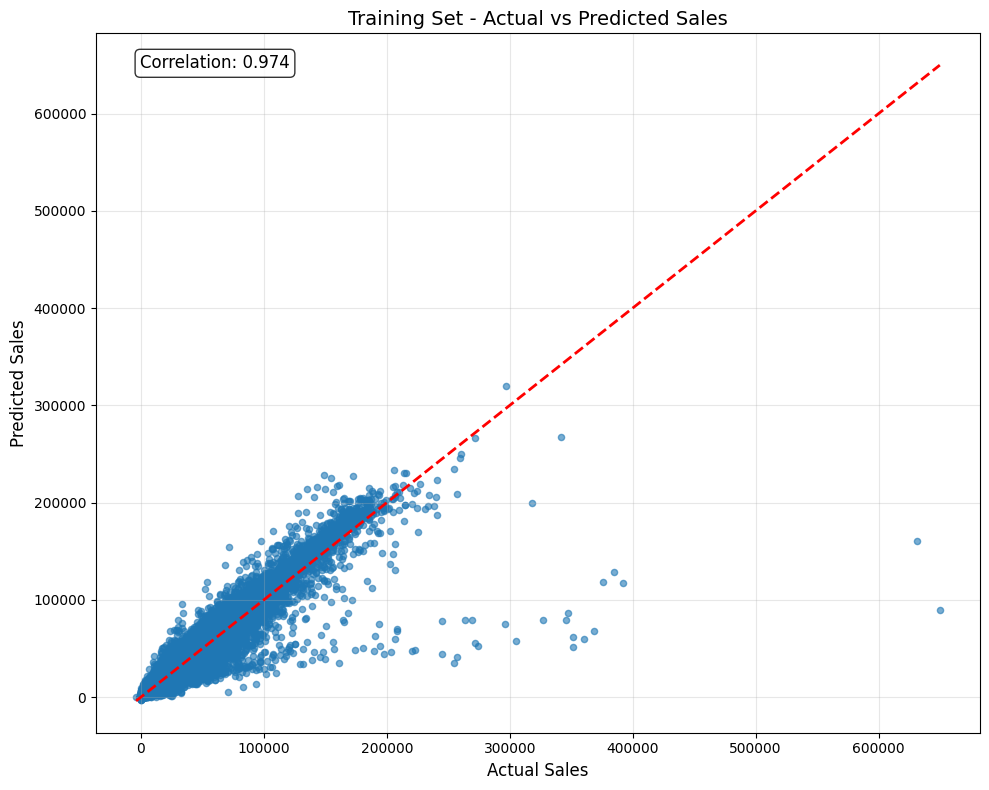

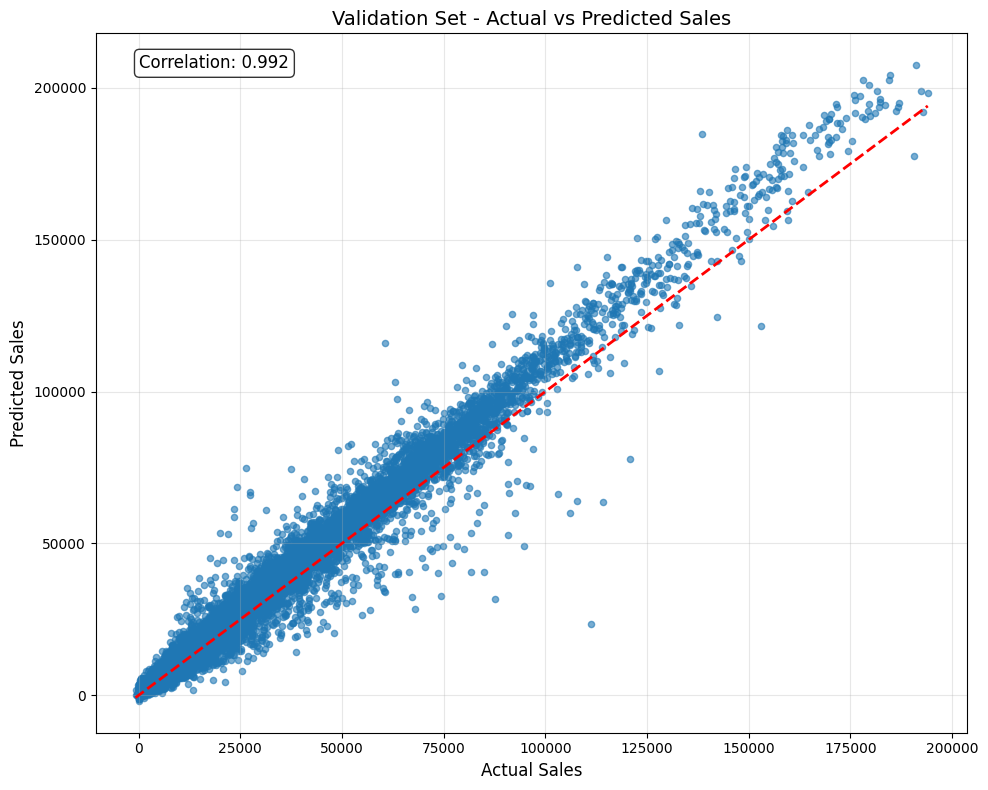


TRAINING COMPLETE
Final Validation WMAE: 1885.12
Model Bias: 1487.36 (Over-predicting)
Prediction Consistency (Std): 3509.02
Store Performance Range: 3150.43
Number of features used: 15
🏃 View run DLinear_with_Lag_Features at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/8/runs/2c121be2024448659d2f5c0fcf2a7527
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/8


In [242]:
mlflow.set_experiment(config.experiment_name)

with mlflow.start_run(run_name="DLinear_with_Lag_Features"):
    mlflow.log_params(vars(config))
    mlflow.log_param("n_features", n_features)
    mlflow.log_param("total_samples", len(X))

    model = DLinearWithLags(config.lookback, config.horizon, n_features).to('cpu')
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

    train_losses, val_losses = [], []

    print("Starting training...")
    for epoch in range(config.epochs):
        model.train()
        train_loss = 0
        for batch_x, batch_y, batch_holiday in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_x)
            loss = weighted_mae_loss(predictions, batch_y, batch_holiday)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y, batch_holiday in val_loader:
                predictions = model(batch_x)
                loss = weighted_mae_loss(predictions, batch_y, batch_holiday)
                val_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{config.epochs}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    train_true, train_pred, train_wmae, train_bias, train_std, train_store_stats = evaluate_model(
        model, train_loader, "Training Set"
    )

    val_true, val_pred, val_wmae, val_bias, val_std, val_store_stats = evaluate_model(
        model, val_loader, "Validation Set"
    )

    plot_actual_vs_predicted(train_true, train_pred, "Training Set")
    plot_actual_vs_predicted(val_true, val_pred, "Validation Set")

    mlflow.log_metrics({
        'train_wmae': train_wmae,
        'train_bias': train_bias,
        'train_error_std': train_std,
        'val_wmae': val_wmae,
        'val_bias': val_bias,
        'val_error_std': val_std,
        'train_store_mae_range': train_store_stats['mean'].max() - train_store_stats['mean'].min(),
        'val_store_mae_range': val_store_stats['mean'].max() - val_store_stats['mean'].min(),
        'n_features': n_features
    })

    torch.save(model.state_dict(), "dlinear_lag_model.pth")
    mlflow.log_artifact("dlinear_lag_model.pth")

    print(f"\n{'='*60}")
    print("TRAINING COMPLETE")
    print(f"{'='*60}")
    print(f"Final Validation WMAE: {val_wmae:.2f}")
    print(f"Model Bias: {val_bias:.2f} ({'Over' if val_bias > 0 else 'Under'}-predicting)")
    print(f"Prediction Consistency (Std): {val_std:.2f}")
    print(f"Store Performance Range: {val_store_stats['mean'].max() - val_store_stats['mean'].min():.2f}")
    print(f"Number of features used: {n_features}")